<a href="https://colab.research.google.com/github/LaviJ/Cryptocurrency-Analysis/blob/main/Machine%20Learning/model-predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


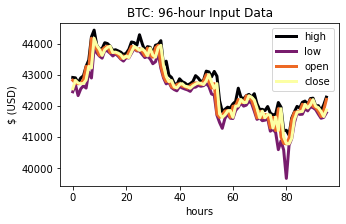

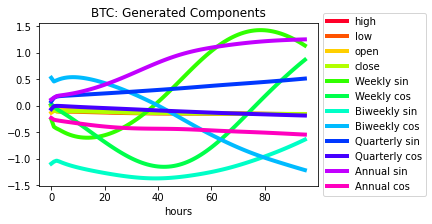

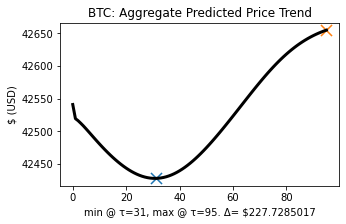

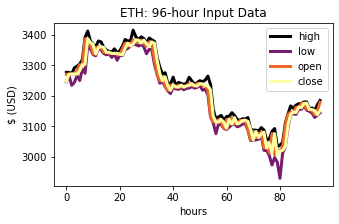

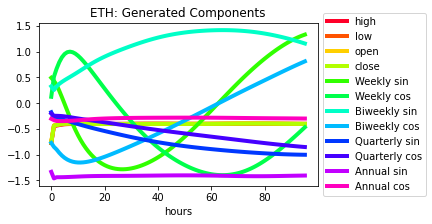

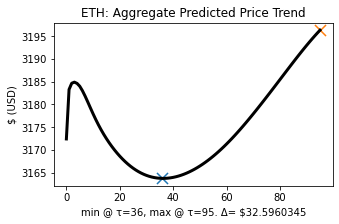

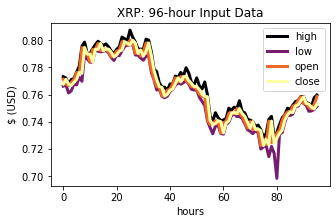

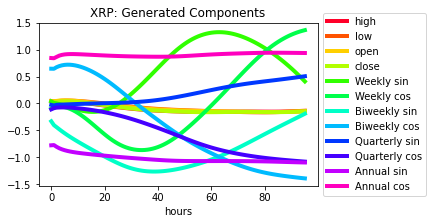

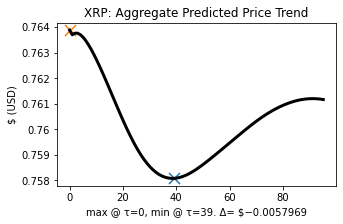

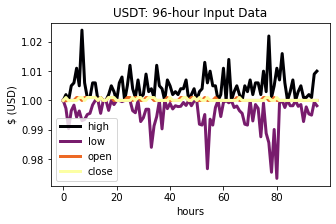

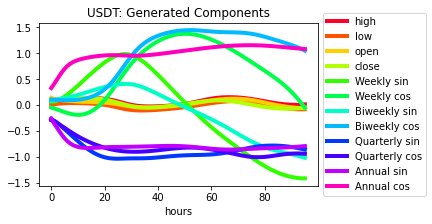

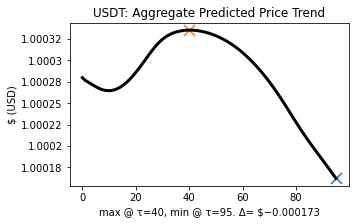

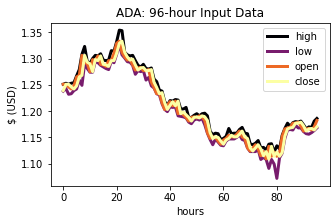

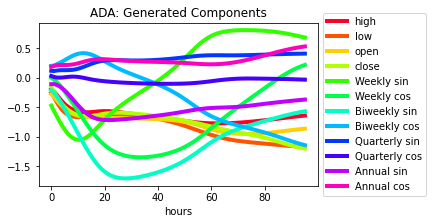

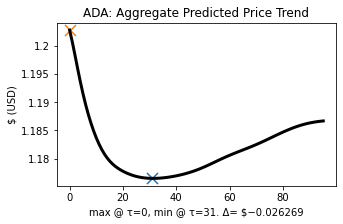

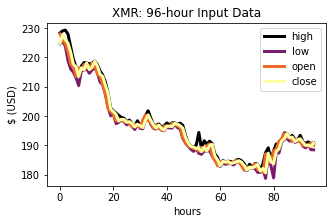

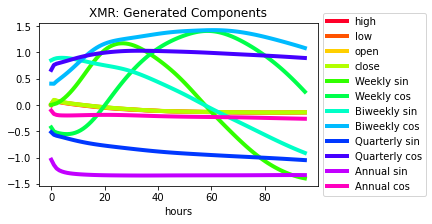

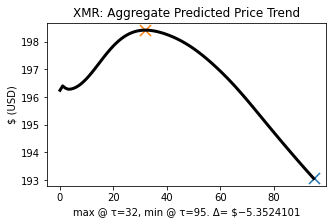

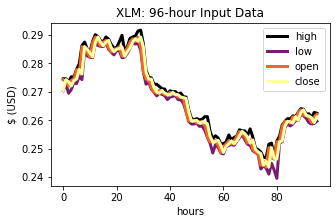

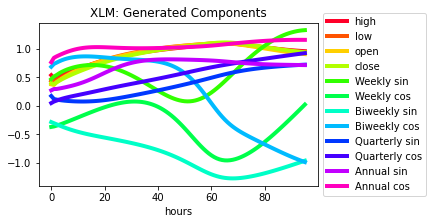

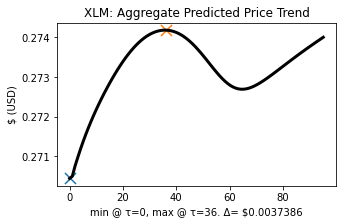

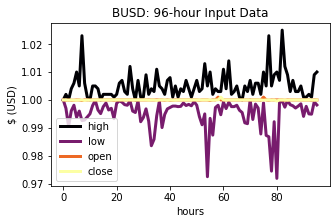

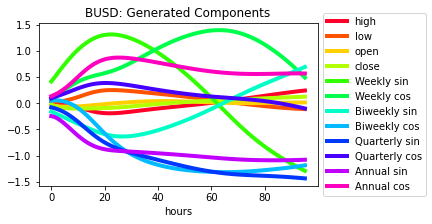

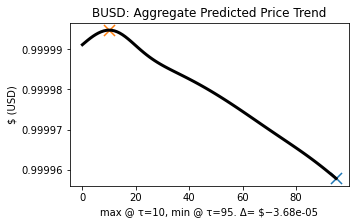

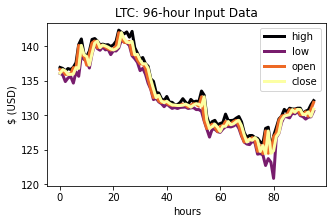

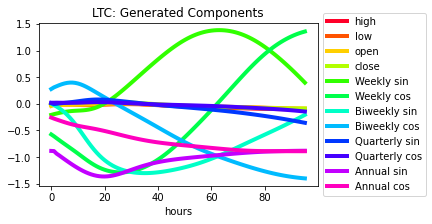

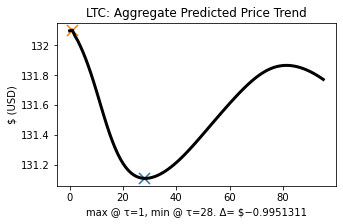

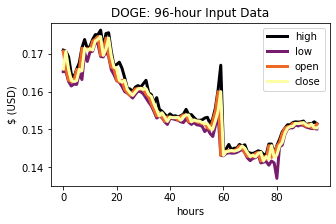

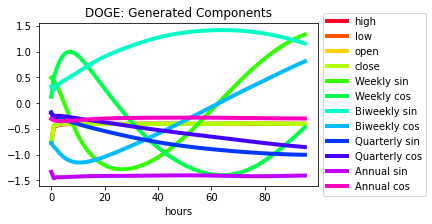

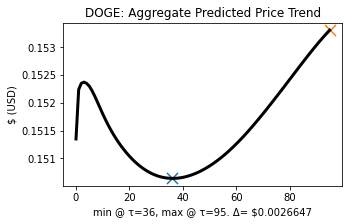

In [1]:
# Forcasting Cryptocurrency
# Data Analysis and Visualization
# Group 7

# TensorFlow model prediction routine

import os
import datetime
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

symbols=['BTC','ETH','XRP','USDT','ADA','XMR','XLM','BUSD','LTC','DOGE']

for symbol in symbols:
    # Declare the dataframes
    train_df = val_df = test_df = df = pd.DataFrame()

    # Load the trained tensorflow model
    # TODO: make coin variable
    feedback_model = keras.models.load_model(symbol+'feedback_model')

    # Use Keras to get the data file
    path = tf.keras.utils.get_file(
        origin='https://raw.githubusercontent.com/LaviJ/Cryptocurrency-Analysis/hourly-ML2/Data/Hourly/Test/test_'+symbol+'.csv',
        fname='test_'+symbol+'.csv')
    csv_path, _ = os.path.splitext(path)

    # Read data into dataframe
    df = pd.read_csv(csv_path+".csv")

    # Drop some columns
    df = df.drop('conversionType', axis=1)
    df = df.drop('conversionSymbol', axis=1)
    df = df.drop('volumeto', axis=1)
    df = df.drop('volumefrom', axis=1)

    # Drop row with any zero
    df = df[(df != 0).all(1)]

    # Drop last row
    df = df[:-1]

    # Move the timestamps into an array
    date_time =[0]
    date_time = df.pop('time')


    # Tensorflow Routines for Time Series Data
    # https://www.tensorflow.org/tutorials/structured_data/time_series

    '''Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
    Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
    Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
    Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
    Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
    Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
    Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
    Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
    Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
    Yuan Yu, and Xiaoqiang Zheng.'''

    # TensorFlow: Large-scale machine learning on heterogeneous systems,
    # 2015. Software available from tensorflow.org.

    class FeedBack(tf.keras.Model):
      def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def call(self, inputs, training=None):
      # Use a TensorArray to capture dynamically unrolled outputs.
      predictions = []
      # Initialize the LSTM state.
      prediction, state = self.warmup(inputs)

      # Insert the first prediction.
      predictions.append(prediction)

      # Run the rest of the prediction steps.
      for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

      # predictions.shape => (time, batch, features)
      predictions = tf.stack(predictions)
      # predictions.shape => (batch, time, features)
      predictions = tf.transpose(predictions, [1, 0, 2])
      return predictions

    def warmup(self, inputs):
      # inputs.shape => (batch, time, features)
      # x.shape => (batch, lstm_units)
      x, *state = self.lstm_rnn(inputs)

      # predictions.shape => (batch, features)
      prediction = self.dense(x)
      return prediction, state
      
    class WindowGenerator():
      def __init__(self, input_width, label_width, shift,
                  train_df=train_df, val_df=val_df, test_df=test_df,
                  label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

      def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example
    FeedBack.warmup = warmup
    FeedBack.call = call

    column_indices = {name: i for i, name in enumerate(df.columns)}

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]

    MAX_EPOCHS = 20
    OUT_STEPS = 96

    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                              kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

    multi_window = WindowGenerator(input_width=96,
                                  label_width=OUT_STEPS,
                                  shift=OUT_STEPS)
    multi_window

    # Adapt input array dimensions to fit trained model shape [None, 96, 12] 

    x = tf.zeros([1, 96, 12], dtype=tf.dtypes.float32, name="inputs")
    x = tf.ensure_shape(x, [1, 96, 12])
    tf.expand_dims(x, 1, name="inputs")

    # Run feedback model prediction on input data
    answer = feedback_model.predict(x, False)

    # Put the answer into a dataframe
    final = pd.DataFrame(answer[0])

    # Show the input data
    df.plot(legend=True, figsize=(5,3), xlabel='hours', ylabel='$ (USD)', colormap='inferno', title=symbol+': 96-hour Input Data', lw=3)
    plt.savefig('pngs/'+symbol+'in.png',bbox_inches='tight',dpi=150)

    # Recombine normalized components
    wow = np.zeros(96)
    for i in range(96):
      for j in range(12):
        wow[i] += final[j][i]

    # Show the raw componenet output
    final.columns = ['high',	'low',	'open',	'close',	'Weekly sin',	
                     'Weekly cos',	'Biweekly sin',	'Biweekly cos',	
                     'Quarterly sin',	'Quarterly cos',	'Annual sin',	'Annual cos']
    final.plot(legend=True, figsize=(5,3), xlabel='hours', colormap='gist_rainbow', title=symbol+': Generated Components', lw=4)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('pngs/'+symbol+'raw.png',bbox_inches='tight',dpi=150)

    # Denormalize
    for k in range(96):
        wow[k] = ( wow[k]/12 * np.std(df['close'] )) + np.mean(df['close'])

    # Plot the aggregate prediction
    a = pd.DataFrame(wow)

    ymin = float(np.min(wow))
    xmin = int(np.where(wow == ymin)[0][0])
    ymax = float(np.max(wow))
    xmax = int(np.where(wow == ymax)[0][0])
    if xmin < xmax :
        a.plot(legend=False, figsize=(5,3), xlabel='min @ \u03C4='+str(xmin)+', max @ \u03C4='+str(xmax)+'. \u0394= $'+str(round(ymax-ymin,7)), ylabel='$ (USD)', color='k', title=symbol+": Aggregate Predicted Price Trend", lw=3)
    else:
        a.plot(legend=False, figsize=(5,3), xlabel='max @ \u03C4='+str(xmax)+', min @ \u03C4='+str(xmin)+'. \u0394= $\u2212'+str(abs(round(ymin-ymax,7))), ylabel='$ (USD)', color='k', title=symbol+": Aggregate Predicted Price Trend", lw=3)
    
    plt.gca().scatter(xmin, ymin, s=123, marker='x')
    plt.gca().scatter(xmax, ymax, s=123, marker='x')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.savefig('pngs/'+symbol+'out.png', bbox_inches='tight', dpi=150)